In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import head
import numpy as np
import matplotlib.pyplot as plt
import pdb
import warnings
warnings.filterwarnings("ignore")

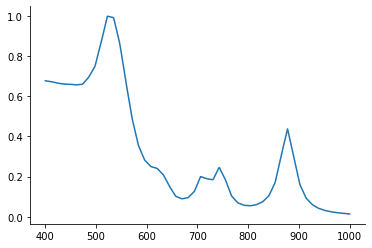

In [3]:
from pyGDM2 import (structures, materials, core, 
                    linear, fields, propagators, 
                    tools
                   )

def get_spectrum(l, r):
    """ Obtain a simulated absorption spectra for a hexagonal nanorod mesh
    L -- length of the cylinder
    R -- radius of the cylinder
    """
    step = 20
    geometry = structures.nanorod(step, L=l, R=r, mesh='hex')
    material = materials.gold()
    struct = structures.struct(step, geometry, material, verbose=False)
    field_generator = fields.plane_wave
    wavelengths = np.linspace(400, 1000, 50)
    kwargs = dict(theta=0, inc_angle=180)

    efield = fields.efield(field_generator,
                   wavelengths=wavelengths, kwargs=kwargs)
    n1 = n2 = 1.0
    dyads = propagators.DyadsQuasistatic123(n1=n1, n2=n2)

    sim = core.simulation(struct, efield, dyads)
    sim.scatter(verbose=False)
    field_kwargs = tools.get_possible_field_params_spectra(sim)

    config_idx = 0
    wl, spectrum = tools.calculate_spectrum(sim,
                        field_kwargs[config_idx], linear.extinct)
    
    abs_ = spectrum.T[2]/np.max(spectrum.T[2])
    
    return head.UVVis(wl, abs_)

fd = get_spectrum(3, 2)
fd.plot()

In [4]:
# create a search space
# we create it using sqrt(L) and L/D by following this paper: 
# https://pubs.acs.org/action/showCitFormats?doi=10.1021/acs.jpcc.0c10680&ref=pdf

X = np.linspace(1,2, num=10) # sqrt(L)
Y = np.linspace(1,2, num=10) # l/D
grid = head.Euclidean(X,Y)

def get_params(p):
    L = p[1]**2
    R = 0.5*(L/p[0])
    
    return [L,R]

In [5]:
# define multiple loss functions
from skfda.misc.metrics import LpDistance
from scipy.spatial import distance

def func_norm(query, target):
    d = LpDistance(p=2)
    val = -d(query.fd, target.fd)
    return float(val)

def euclidean_dist(query, target):
    val = -distance.euclidean(query.fd.data_matrix, target.fd.data_matrix)
    return float(val)

In [6]:
from modAL.models import BayesianOptimizer
from sklearn.gaussian_process import GaussianProcessRegressor
from modAL.acquisition import max_EI

class Design:
    def __init__(self, dspace):
        self.dspace = dspace
        self.Lt, self.Rt = 3, 4/3
        self.st = get_spectrum(self.Lt,self.Rt)
    
    def run(self, oracle, n_queries=5):
        # Bayesian optimization
        regressor = GaussianProcessRegressor()
        # create intialization samples
        self.X0 = grid.sample(n_samples=5)
        Y0 = []
        for x0 in self.X0:
            Y0.append(self._get_score(x0, oracle))
        
        self.Y0 = np.asarray(Y0)
        self.optimizer = BayesianOptimizer(
            estimator=regressor,
            query_strategy=max_EI,
            X_training = self.X0,
            y_training = self.Y0
        )
        
        self.loss_evol = []
        
        for n_query in range(n_queries):
            query_idx, query_inst = self.optimizer.query(grid.space)
            Xb, Yb = [],[]
            for qid in query_idx:
                xi = self.dspace[query_idx]
                Xb.append(xi)
                Yb.append(self._get_score(xi, oracle))
            self.loss_evol.append(Yb)
            
        self.optimizer.teach(np.asarray(Xb), np.asarray(Yb))
        
    def _get_score(self,xi,oracle):
        pi = get_params(xi)
        si = get_spectrum(pi[0],pi[1])
        yi = oracle(si, self.st)
        
        return yi
                
    def plot_bestmatch(self):
        X_max, y_max = self.optimizer.get_max()
        p = get_params(X_max)
        sbest = get_spectrum(p[0],p[1])
        fig, ax = plt.subplots()
        sbest.plot(ax, label='Best')
        self.st.plot(ax, label='Target')
        ax.set_title('Oracle score {:.2f}'.format(float(y_max)))
        plt.show()
        
    def plot_learning(self):
        y_pred, y_std = self.optimizer.predict(self.dspace.space, return_std=True)
        X_max, y_max = self.optimizer.get_max()
        fig, axs = plt.subplots(1,2,figsize=(2*4*1.6,4))
        im = axs[0].contourf(self.dspace.mesh[0], self.dspace.mesh[1], 
                         y_pred.reshape(10,10), cmap='RdYlGn')
        fig.colorbar(im, ax=axs[0])

        axs[0].set_xlabel(r'$\sqrt{L}$')
        axs[0].set_ylabel(r'$L/D$')
        axs[0].scatter(self.optimizer.X_training[:,0], self.optimizer.X_training[:,1], 
                   s=25, color='k', label='Queried')
        axs[0].scatter(X_max[0],X_max[1],s=100,marker='*',label='best',color='tab:blue',)
        axs[0].scatter(np.sqrt(self.Lt),self.Lt/(2*self.Rt),s=100,color='tab:red',marker='*',label='Target')
        axs[0].legend()
        
        axs[1].scatter(np.arange(len(self.loss_evol)), self.loss_evol)
        axs[1].set_xlabel('Query Index')
        axs[1].set_ylabel('Oracle value')
                       
        for ax in axs:
            ax.spines.right.set_visible(False)
            ax.spines.top.set_visible(False)
            ax.yaxis.set_ticks_position('left')
            ax.xaxis.set_ticks_position('bottom')
        plt.show()

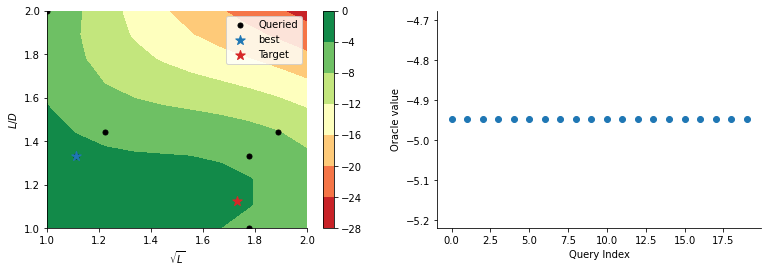

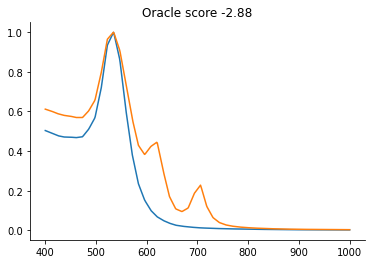

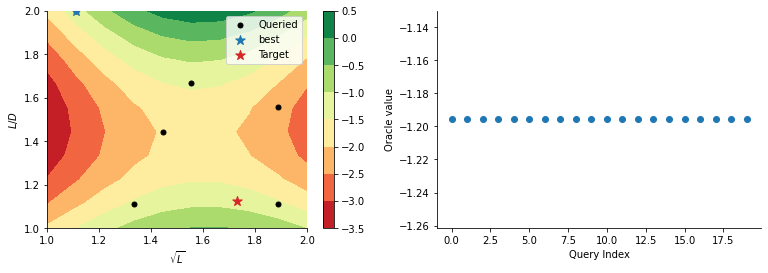

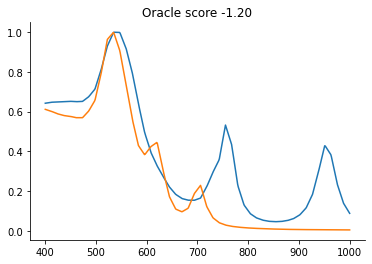

In [7]:
design = Design(grid)
for oracle in [func_norm, euclidean_dist]:
    design.run(oracle, n_queries=20)
    design.plot_learning()
    design.plot_bestmatch()